<a href="https://colab.research.google.com/github/farshidehkordi/Homework2_AI/blob/main/TP2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os


# List files in the current directory
print(os.listdir())

['.config', 'drive', 'codeTP2.zip', 'sample_data']


In [4]:
!unzip ./codeTP2.zip
# extract files


Archive:  ./codeTP2.zip
   creating: code/data-q2/
  inflating: code/data-q2/test.txt   
  inflating: code/data-q2/train.txt  
  inflating: code/q2-RNN.py          
  inflating: code/question1.py       


In [5]:
!pip install poutyne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

Initial architecture with the WordClassifier class

In [8]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model


import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model

# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# bidirectional
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)  # Bidirectional RNN
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden size by 2 for bidirectional RNN

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)

        output, _ = self.rnn(embedded)  # Shape: (batch_size, seq_len, hidden_size * 2) because it's bidirectional

        # Take the last output of the sequence
        last_output = output[:, -1, :]

        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)
        return logits





class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)
        output, _ = self.rnn(embedded)     # Shape: (batch_size, seq_len, hidden_size)
        last_output = output[:, -1, :]     # Take the last output of the sequence
        logits = self.fc(last_output)      # Shape: (batch_size, num_classes)
        return logits



def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            vectorized_word.append(char_to_idx.get(char, 1))  # Get the char index otherwise set to unknown char
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)

def collate_examples(samples):
    # Get the length of the longest sequence in the batch
    max_len = max(len(word) for word, _ in samples)

    # Initialize lists to store padded sequences and labels
    padded_sequences = []
    labels = []

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Convert the tensor to a Python list
        word_list = word.tolist()

        # Pad the sequence with the padding token ("<pad>") to match the maximum length
        padded_sequence = torch.tensor(word_list + [0] * (max_len - len(word_list)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor





def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")


    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 1: Create a simple network that takes inputs of fixed length (max length)
    network = WordClassifier(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))



if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()



Epoch: 1/5 Train steps: 1696 13.74s loss: 2.294531 acc: 12.554144                               
Epoch: 2/5 Train steps: 1696 13.61s loss: 2.290366 acc: 13.035685                                
Epoch: 3/5 Train steps: 1696 14.55s loss: 2.290358 acc: 13.035685                                
Epoch: 4/5 Train steps: 1696 13.93s loss: 2.290369 acc: 13.035685                                
Epoch: 5/5 Train steps: 1696 17.52s loss: 2.290363 acc: 13.035685                               
Test steps: 424 1.10s test_loss: 2.291355 test_acc: 13.044200                                 


INFO:root:1 - Loss: 2.2913547344853225	Acc:13.044199506378764


Adding the collate_examples function

In [9]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model


import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model

# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# bidirectional
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)  # Bidirectional RNN
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden size by 2 for bidirectional RNN

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)

        output, _ = self.rnn(embedded)  # Shape: (batch_size, seq_len, hidden_size * 2) because it's bidirectional

        # Take the last output of the sequence
        last_output = output[:, -1, :]

        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)
        return logits





class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)
        output, _ = self.rnn(embedded)     # Shape: (batch_size, seq_len, hidden_size)
        last_output = output[:, -1, :]     # Take the last output of the sequence
        logits = self.fc(last_output)      # Shape: (batch_size, num_classes)
        return logits



def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            vectorized_word.append(char_to_idx.get(char, 1))  # Get the char index otherwise set to unknown char
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)

import torch

def collate_examples(samples):
    # Get the length of the longest sequence in the batch
    max_len = max(len(word) for word, _ in samples)

    # Initialize lists to store padded sequences and labels
    padded_sequences = []
    labels = []

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Pad the sequence with the padding token ("<pad>") to match the maximum length
        padded_sequence = torch.tensor(word + [0] * (max_len - len(word)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor






def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")


    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 1: Create a simple network that takes inputs of fixed length (max length)
    network = WordClassifier(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))

    # 2: Faites en sorte que le padding soit fait "on batch"
    # Le tout devrait se passer dans la fonction collate_examples
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))




if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()



Epoch: 1/5 Train steps: 1696 14.21s loss: 2.294531 acc: 12.554144                                
Epoch: 2/5 Train steps: 1696 14.89s loss: 2.290366 acc: 13.035685                                
Epoch: 3/5 Train steps: 1696 14.29s loss: 2.290358 acc: 13.035685                                
Epoch: 4/5 Train steps: 1696 14.35s loss: 2.290369 acc: 13.035685                                
Epoch: 5/5 Train steps: 1696 14.42s loss: 2.290363 acc: 13.035685                                
Test steps: 424 1.26s test_loss: 2.291355 test_acc: 13.044200                                 


INFO:root:1 - Loss: 2.2913547344853225	Acc:13.044199506378764


Epoch: 1/5 Train steps: 1696 11.04s loss: 2.290117 acc: 13.206643                                
Epoch: 2/5 Train steps: 1696 10.96s loss: 2.289502 acc: 13.222771                                
Epoch: 3/5 Train steps: 1696 10.77s loss: 2.288023 acc: 13.273920                                
Epoch: 4/5 Train steps: 1696 10.69s loss: 1.943796 acc: 22.621330                                
Epoch: 5/5 Train steps: 1696 10.47s loss: 1.856222 acc: 23.683944                                
Test steps: 424 0.97s test_loss: 1.782388 test_acc: 24.103292                                 


INFO:root:2 - Loss: 1.7823883576394357	Acc:24.103291924582408


Added WordClassifierHandlingPadding function

In [16]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model

# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# bidirectional
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)  # Bidirectional RNN
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden size by 2 for bidirectional RNN

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)

        output, _ = self.rnn(embedded)  # Shape: (batch_size, seq_len, hidden_size * 2) because it's bidirectional

        # Take the last output of the sequence
        last_output = output[:, -1, :]

        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)
        return logits


class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # If inputs is a tuple, assume it contains sequences and lengths
        if isinstance(inputs, tuple):
            sequences, lengths = inputs
        # If inputs is not a tuple, assume it contains only sequences and compute lengths
        else:
            sequences = inputs
            lengths = torch.count_nonzero(sequences, dim=1).cpu().tolist()

        # Embed the sequences
        embedded = self.embedding(sequences)  # Shape: (batch_size, seq_len, embedding_size)

        # Pack the embedded sequences to handle padding
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # Pass the packed sequences through the RNN
        packed_output, _ = self.rnn(packed_embedded)

        # Unpack the packed output
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Take the last output of each sequence
        last_output = output[:, -1, :]

        # Pass the last output through the mapping layer
        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)

        return logits




def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            vectorized_word.append(char_to_idx.get(char, 1))  # Get the char index otherwise set to unknown char
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)

import torch

def collate_examples(samples):
    # Get the length of the longest sequence in the batch
    max_len = max(len(word) for word, _ in samples)

    # Initialize lists to store padded sequences and labels
    padded_sequences = []
    labels = []

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Pad the sequence with the padding token ("<pad>") to match the maximum length
        padded_sequence = torch.tensor(word + [0] * (max_len - len(word)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor






def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")


    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 1: Create a simple network that takes inputs of fixed length (max length)
    network = WordClassifier(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))

    # 2: Faites en sorte que le padding soit fait "on batch"
    # Le tout devrait se passer dans la fonction collate_examples
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))


   # 3: Créez une architecture qui gère convenablement des séquences de longueur différentes
    network = WordClassifierHandlingPadding(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("3 - Loss: {}\tAcc:{}".format(loss, acc))




if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()



Epoch: 1/5 Train steps: 1696 14.24s loss: 2.294531 acc: 12.554144                                
Epoch: 2/5 Train steps: 1696 14.56s loss: 2.290366 acc: 13.035685                                
Epoch: 3/5 Train steps: 1696 15.05s loss: 2.290358 acc: 13.035685                                
Epoch: 4/5 Train steps: 1696 14.85s loss: 2.290369 acc: 13.035685                                
Epoch: 5/5 Train steps: 1696 14.35s loss: 2.290363 acc: 13.035685                                
Test steps: 424 1.11s test_loss: 2.291355 test_acc: 13.044200                                


INFO:root:1 - Loss: 2.2913547344853225	Acc:13.044199506378764


Epoch: 1/5 Train steps: 1696 10.64s loss: 2.290117 acc: 13.206643                                
Epoch: 2/5 Train steps: 1696 10.36s loss: 2.289502 acc: 13.222771                               
Epoch: 3/5 Train steps: 1696 9.96s loss: 2.288023 acc: 13.273920                                
Epoch: 4/5 Train steps: 1696 10.57s loss: 1.943796 acc: 22.621330                                
Epoch: 5/5 Train steps: 1696 10.97s loss: 1.856222 acc: 23.683944                                
Test steps: 424 0.98s test_loss: 1.782388 test_acc: 24.103292                                 


INFO:root:2 - Loss: 1.7823883576394357	Acc:24.103291924582408


Epoch: 1/5 Train steps: 1696 14.21s loss: 2.300693 acc: 11.490148                                
Epoch: 2/5 Train steps: 1696 15.09s loss: 2.290882 acc: 13.045822                                
Epoch: 3/5 Train steps: 1696 14.41s loss: 2.290111 acc: 13.048587                                
Epoch: 4/5 Train steps: 1696 14.85s loss: 2.289733 acc: 13.057803                               
Epoch: 5/5 Train steps: 1696 14.61s loss: 2.289578 acc: 13.090981                                
Test steps: 424 1.05s test_loss: 2.290335 test_acc: 13.151104                                


INFO:root:3 - Loss: 2.290335214418839	Acc:13.151104066411204


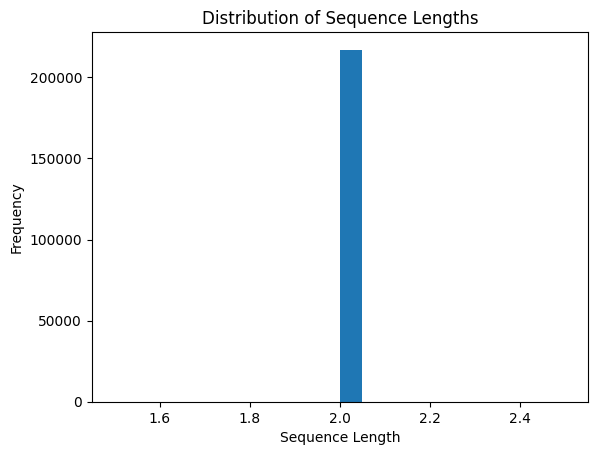

Mean Sequence Length: 2.0
Median Sequence Length: 2.0
Minimum Sequence Length: 2
Maximum Sequence Length: 2
Standard Deviation of Sequence Lengths: 0.0


In [18]:
import matplotlib.pyplot as plt
import numpy as np

dataset = load_data("./code/data-q2/train.txt")
# Assuming dataset is a list of sequences, where each sequence is a list of tokens
# Calculate sequence lengths
sequence_lengths = [len(sequence) for sequence in dataset]

# Visualize the distribution using a histogram
plt.hist(sequence_lengths, bins=20)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Compute descriptive statistics
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
min_length = np.min(sequence_lengths)
max_length = np.max(sequence_lengths)
std_length = np.std(sequence_lengths)

print(f"Mean Sequence Length: {mean_length}")
print(f"Median Sequence Length: {median_length}")
print(f"Minimum Sequence Length: {min_length}")
print(f"Maximum Sequence Length: {max_length}")
print(f"Standard Deviation of Sequence Lengths: {std_length}")


In [6]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model

# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# bidirectional
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)  # Bidirectional RNN
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden size by 2 for bidirectional RNN

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)

        output, _ = self.rnn(embedded)  # Shape: (batch_size, seq_len, hidden_size * 2) because it's bidirectional

        # Take the last output of the sequence
        last_output = output[:, -1, :]

        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)
        return logits


class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # If inputs is a tuple, assume it contains sequences and lengths
        if isinstance(inputs, tuple):
            sequences, lengths = inputs
        # If inputs is not a tuple, assume it contains only sequences and compute lengths
        else:
            sequences = inputs
            lengths = torch.count_nonzero(sequences, dim=1).cpu().tolist()

        # Embed the sequences
        embedded = self.embedding(sequences)  # Shape: (batch_size, seq_len, embedding_size)
        print("Embedded shape:", embedded.shape)

        # Pack the embedded sequences to handle padding
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        print("Packed embedded shape:", packed_embedded.data.shape)

        # Pass the packed sequences through the RNN
        packed_output, _ = self.rnn(packed_embedded)

        # Unpack the packed output
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Take the last output of each sequence
        last_output = output[:, -1, :]

        # Pass the last output through the mapping layer
        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)

        return logits




def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            vectorized_word.append(char_to_idx.get(char, 1))  # Get the char index otherwise set to unknown char
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)

import torch

def collate_examples(samples):
    # Get the length of the longest sequence in the batch
    max_len = max(len(word) for word, _ in samples)

    # Initialize lists to store padded sequences and labels
    padded_sequences = []
    labels = []

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Pad the sequence with the padding token ("<pad>") to match the maximum length
        padded_sequence = torch.tensor(word + [0] * (max_len - len(word)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor


def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")

    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Train WordClassifierHandlingPadding
    network = WordClassifierHandlingPadding(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("3 - Loss: {}\tAcc:{}".format(loss, acc))



if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()






Streaming output truncated to the last 5000 lines.
Packed embedded shape: torch.Size([1016, 10])
Embedded shape: torch.Size([128, 29, 10])
Packed embedded shape: torch.Size([1089, 10])
Epoch: 4/5 Step: 1319/1696  77.77% |███████████████▌    |ETA: 8.62s loss: 2.288426 acc: 11.718750Embedded shape: torch.Size([128, 29, 10])
Packed embedded shape: torch.Size([1101, 10])
Embedded shape: torch.Size([128, 29, 10])
Packed embedded shape: torch.Size([1132, 10])
Embedded shape: torch.Size([128, 29, 10])
Packed embedded shape: torch.Size([1063, 10])
Embedded shape: torch.Size([128, 29, 10])
Packed embedded shape: torch.Size([1113, 10])
Embedded shape: torch.Size([128, 29, 10])
Packed embedded shape: torch.Size([1024, 10])
Epoch: 4/5 Step: 1324/1696  78.07% |███████████████▌    |ETA: 8.50s loss: 2.304228 acc: 14.062500Embedded shape: torch.Size([128, 29, 10])
Packed embedded shape: torch.Size([1064, 10])
Embedded shape: torch.Size([128, 29, 10])
Packed embedded shape: torch.Size([1103, 10])
Embed

INFO:root:3 - Loss: 2.2894373606267933	Acc:13.357540456440189
